# Load packages

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import scipy as sp
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import silhouette_score
import os

# Load MERFISH ventricle object

In [2]:
adata_merfish_subset = sc.read_h5ad('/volume/Projects/Heart_MERFISH_analysis/data/MERFISH/scanpy_obj/merfish_w12_merged_4C4_4C12_4C15_ventricle.h5ad')

# Myocardial wall depth calculation

In [22]:
from sklearn.neighbors import NearestNeighbors

# Function for calculating the depth
def get_depth(adata, targets):
    qdata = adata[~adata.obs['celltype_vent'].isin(targets)] # Cell types to calculate depth for
    tdata = adata[adata.obs['celltype_vent'].isin(targets)] # Cell types to use for depth calculation
    nn = NearestNeighbors(n_jobs=32)
    nn.fit(tdata.obsm['spatial'])
    dist, _ = nn.kneighbors(qdata.obsm['spatial'], n_neighbors=5)
    #dist = dist.mean(axis=1) # Dan suggested using median instead of mean
    dist = np.median(dist, axis=1)
    return pd.Series(data=dist, index=qdata.obs.index)

In [11]:
# Separate the sections
sections = [
    adata_merfish_subset[adata_merfish_subset.obs['sample_id'] == "R77_4C4"],
    adata_merfish_subset[adata_merfish_subset.obs['sample_id'] == "R78_4C12"],
    adata_merfish_subset[adata_merfish_subset.obs['sample_id'] == "R78_4C15"]
]

In [12]:
def plot_celltype_groups(adata, query, targets, ax):
    qdata = adata[adata.obs['celltype_vent'].isin(query)]
    tdata = adata[adata.obs['celltype_vent'].isin(targets)]
    ax.scatter(qdata.obsm['spatial'][:,0], qdata.obsm['spatial'][:,1], s=1, c='r', label=', '.join(query))
    ax.scatter(tdata.obsm['spatial'][:,0], tdata.obsm['spatial'][:,1], s=1, c='b', label=', '.join(targets))
    ax.axis('off')

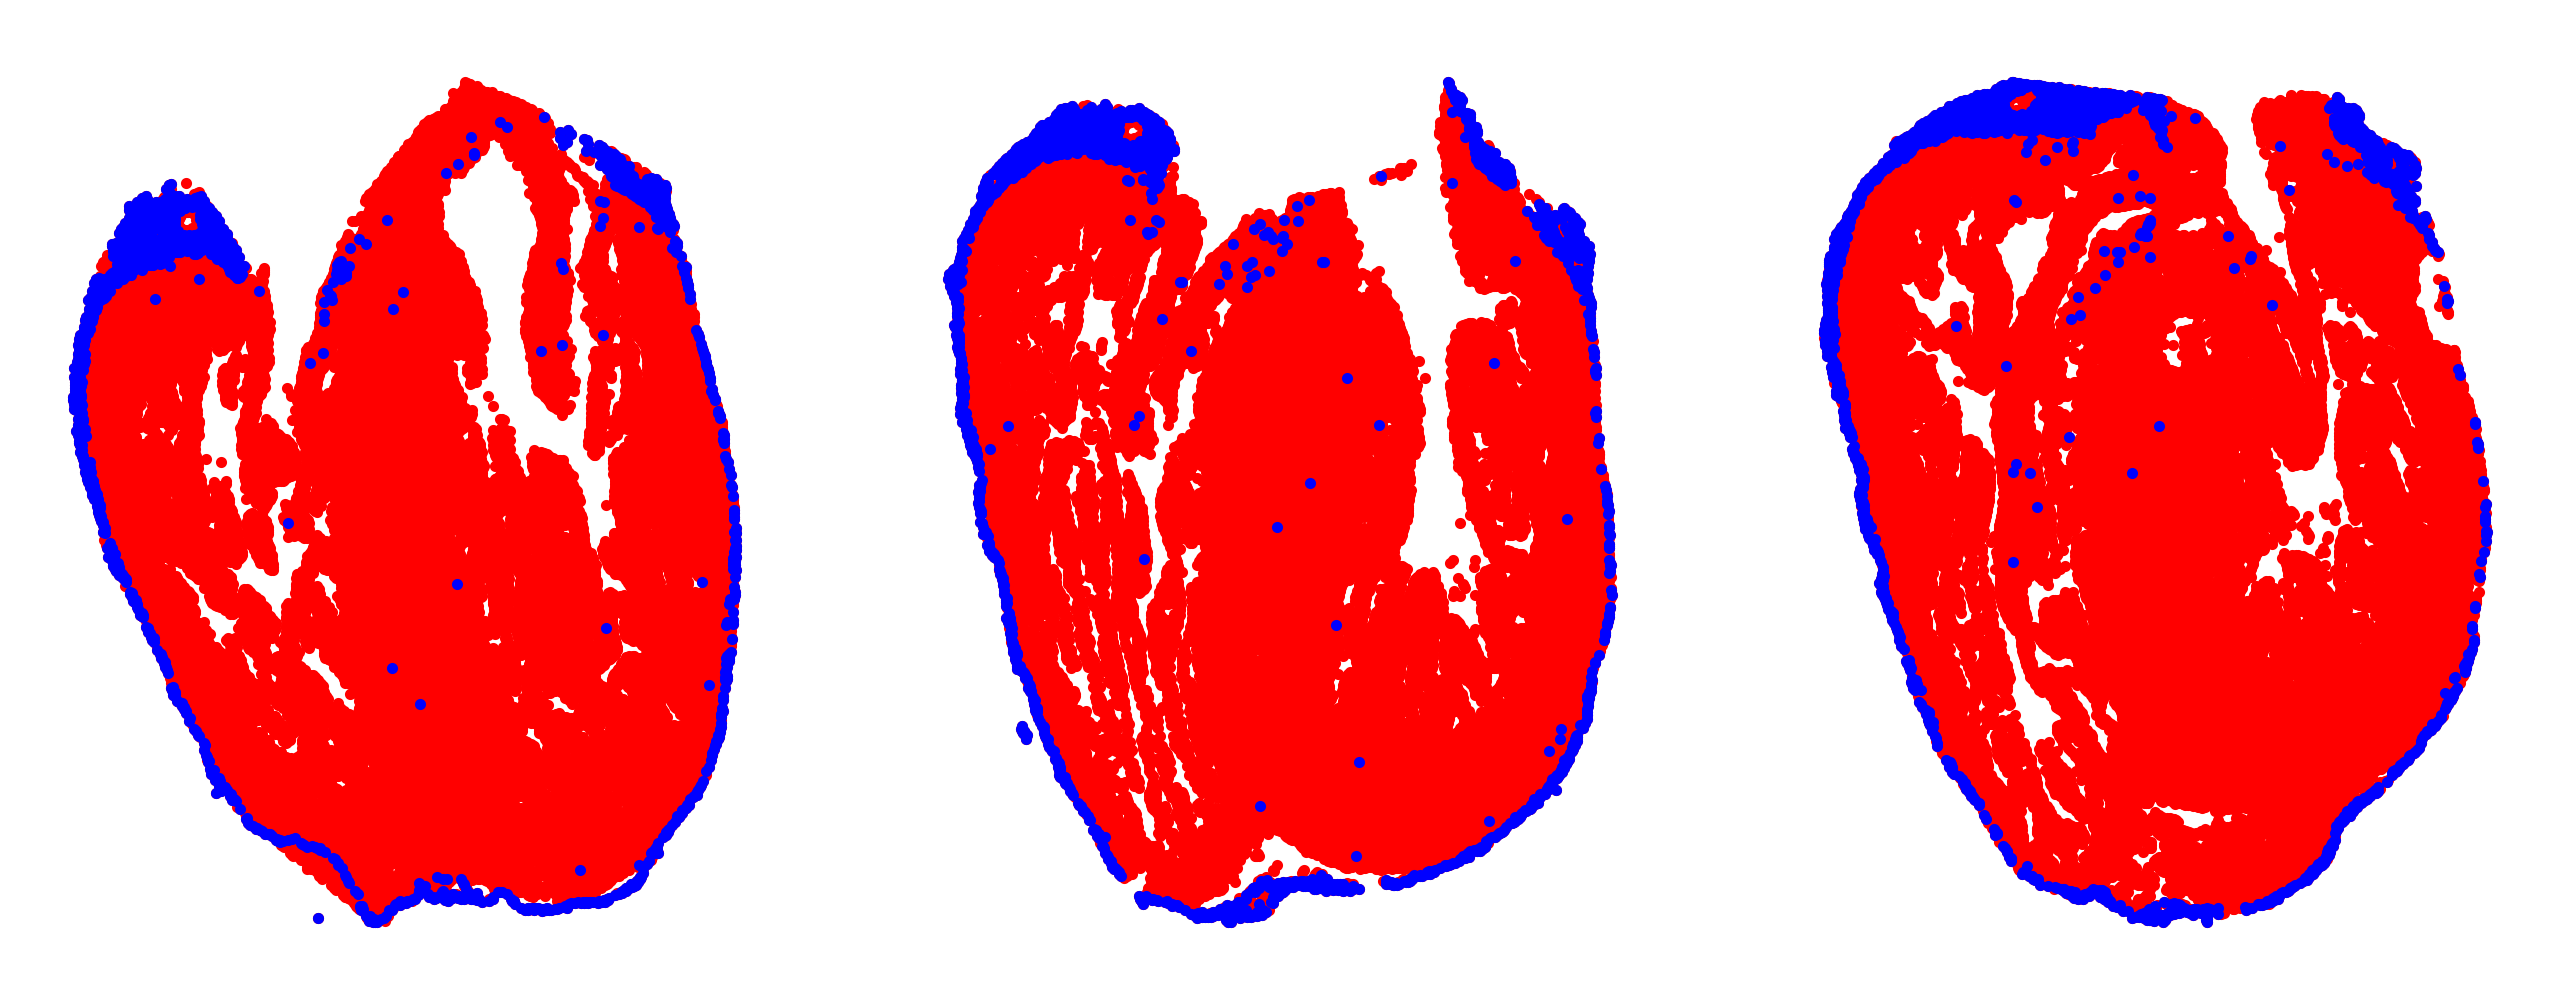

In [14]:
# There are some inner cells labeled as Epicardial/EPDC, we will try to remove them
fig, axs = plt.subplots(1, 3, figsize=(8,3), dpi=200)
for ax, subset in zip(axs, sections):
    plot_celltype_groups(subset, np.unique(subset.obs['celltype_vent']), ["Epicardial", "EPDC"], ax)

In [17]:
def trim_inner_epicardial(batch, bottom, left, right):
    inds = batch[(batch.obs['celltype_vent'].isin(["Epicardial", "EPDC"])) & (batch.obsm["spatial"][:,1] > bottom) & (batch.obsm["spatial"][:,0] > left) & (batch.obsm["spatial"][:,0] < right)]
    return batch[~batch.obs.index.isin(inds.obs.index)]

In [18]:
# Cutting out ones in a box in the middle
subsets = [
    trim_inner_epicardial(sections[0], bottom=-3000, left=-1200-8000, right=1400-8000),
    trim_inner_epicardial(sections[1], bottom=-3850, left=-3500, right=-1000),
    trim_inner_epicardial(sections[2], bottom=-3800, left=-1300+4000, right=1150+4000)
]

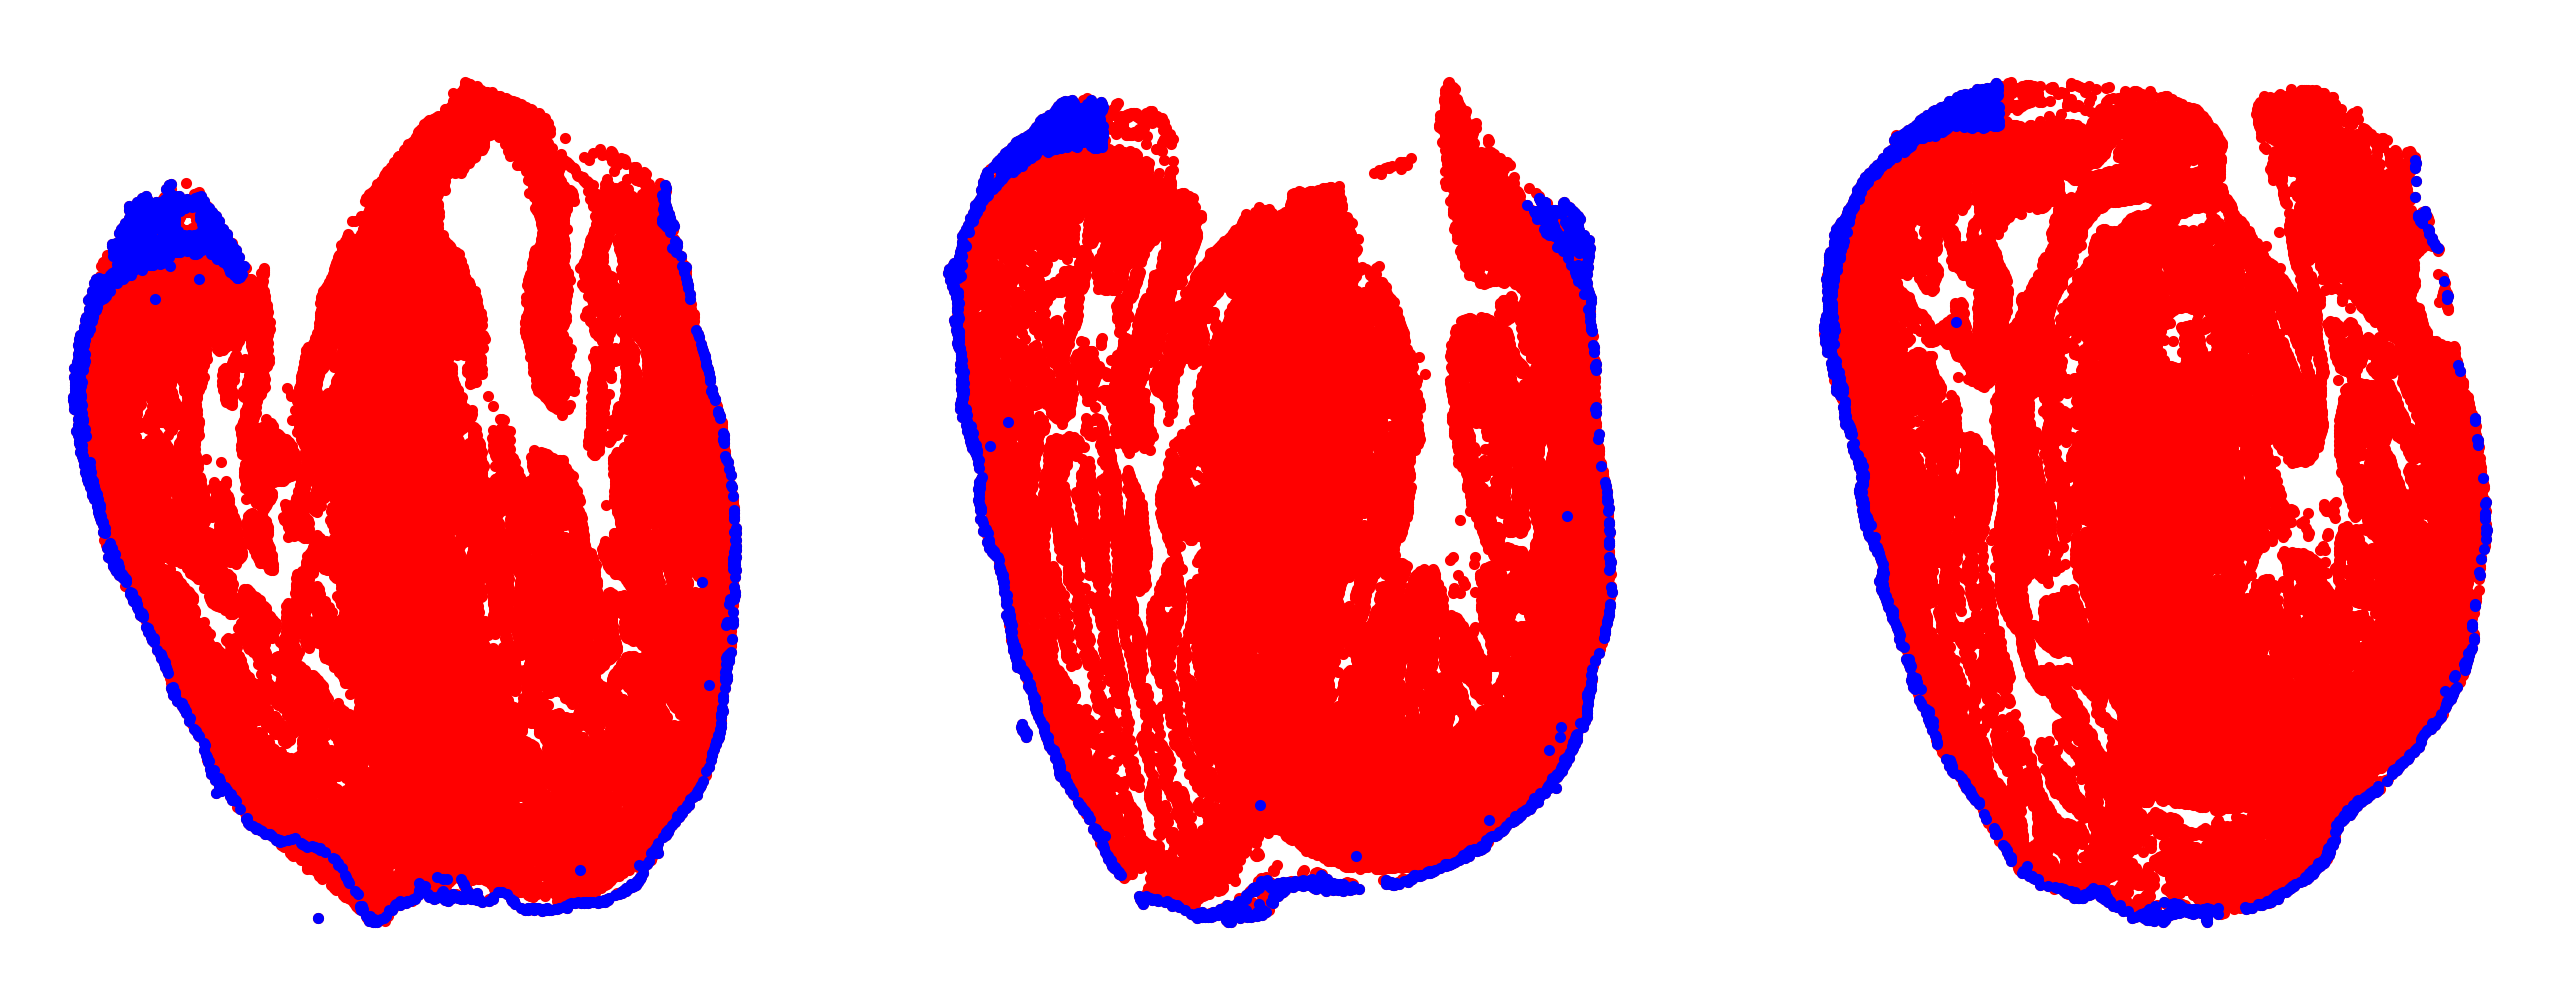

In [20]:
# There are still some close to the outside, might improve results to manually remove them individually
fig, axs = plt.subplots(1, 3, figsize=(8,3), dpi=200)
for ax, subset in zip(axs, subsets):
    plot_celltype_groups(subset, np.unique(subset.obs['celltype_vent']), ["Epicardial", "EPDC"], ax)

In [36]:
# Calculate and assign the depths
depths = pd.concat([get_depth(subset, ['Epicardial', 'EPDC']) for subset in subsets])
adata_merfish_subset.obs['Depth'] = depths
adata_merfish_subset.obs.loc[adata_merfish_subset.obs['celltype_vent'].isin(['Epicardial', 'EPDC']),'Depth'] = 0

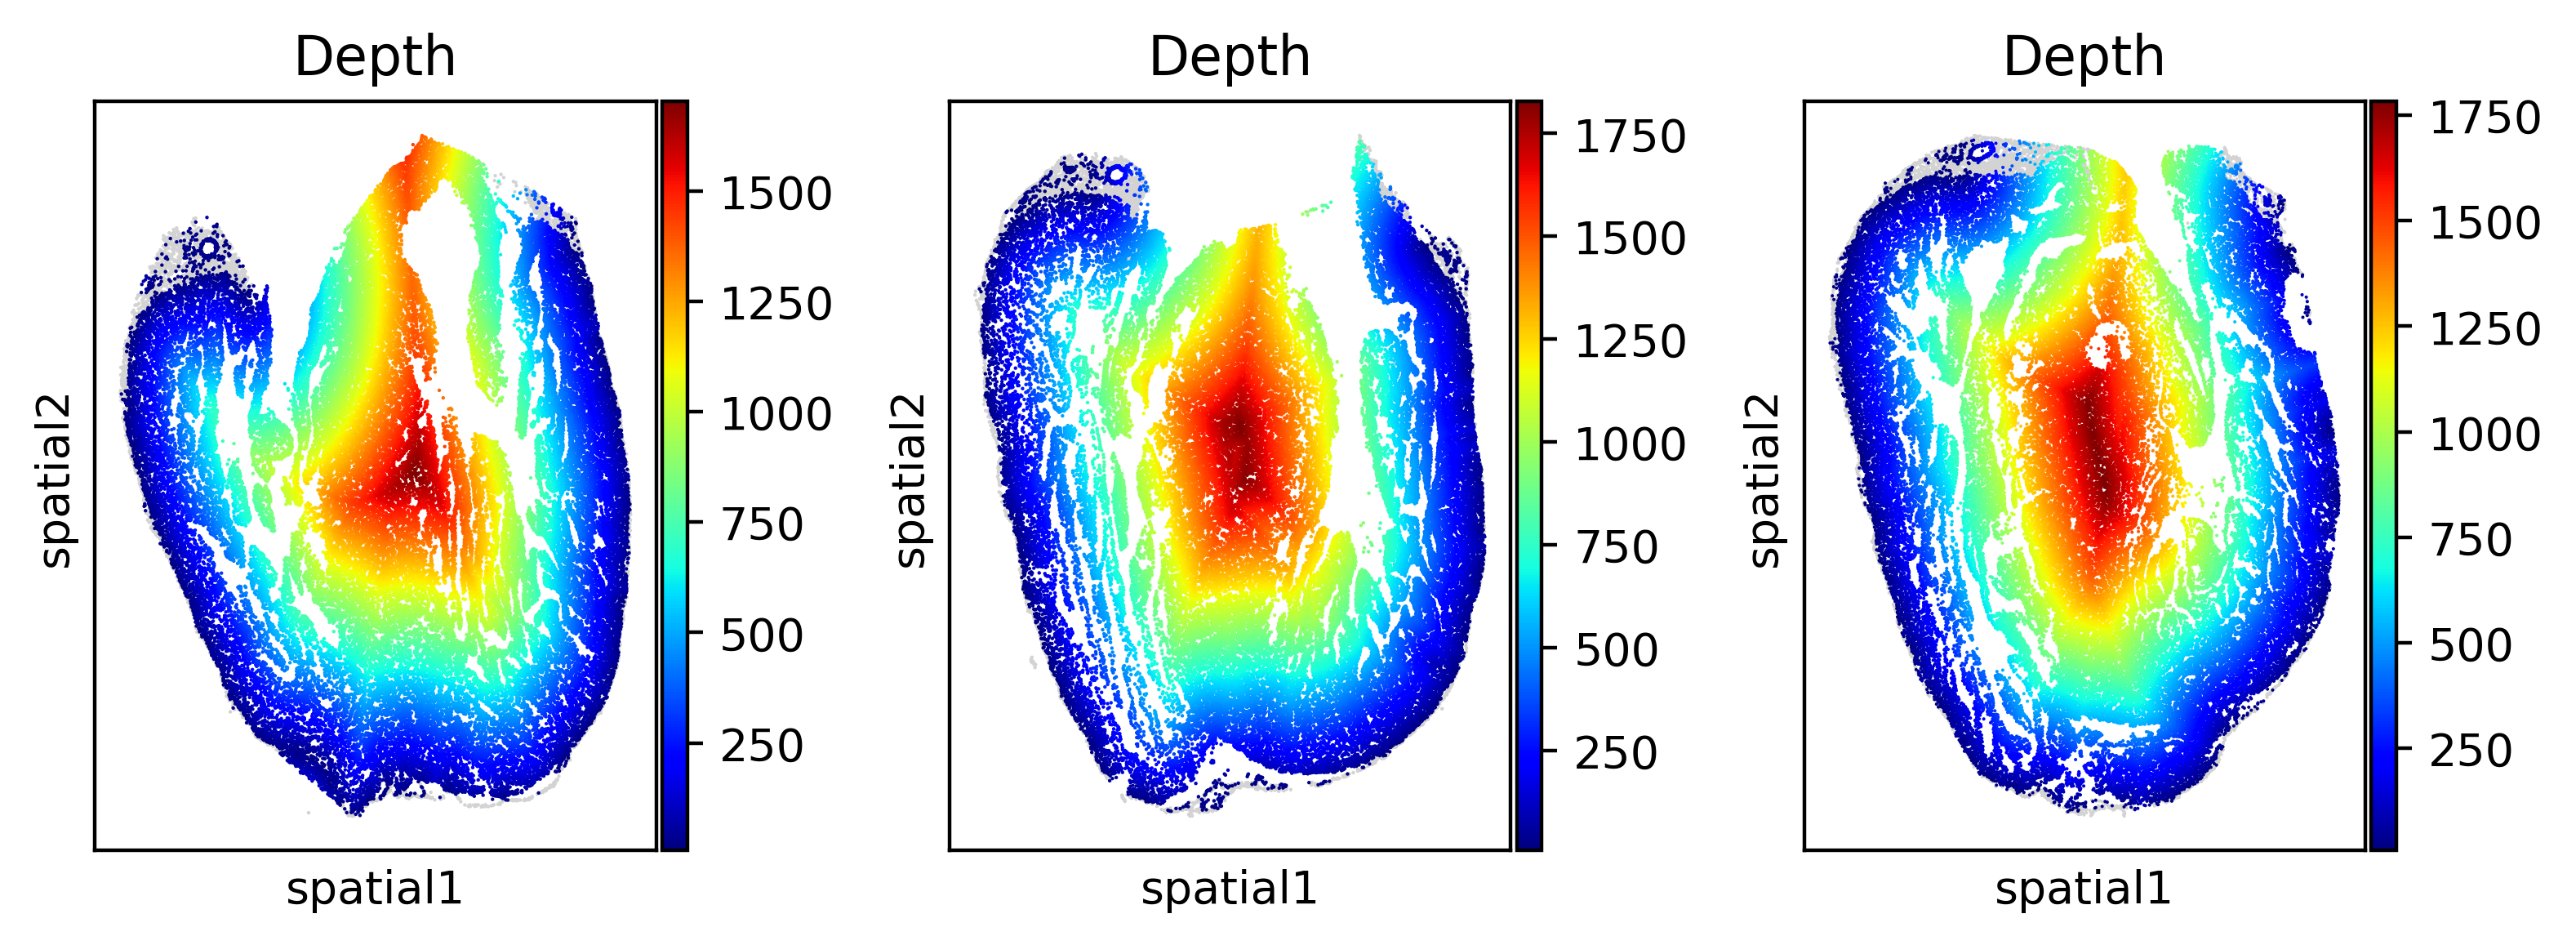

In [26]:
# Check the depths
fig, axs = plt.subplots(1, 3, figsize=(8,3), dpi=200)
for ax, section in zip(axs, ["R77_4C4", "R78_4C12", "R78_4C15"]):
    sc.pl.embedding(adata_merfish_subset[adata_merfish_subset.obs['sample_id'] == section], 
                    basis='spatial', color='Depth', cmap='jet', ax=ax, show=False)
fig.tight_layout()

In [27]:
# adata_merfish_subset.write('/volume/Projects/Heart_MERFISH_analysis/data/MERFISH/scanpy_obj/merfish_w12_merged_4C4_4C12_4C15_ventricle.h5ad')

# LV subset analysis

In [10]:
adata_merfish_view = adata_merfish_subset[adata_merfish_subset.obs['sample_id']=='R78_4C12']

coords = pd.DataFrame(adata_merfish_view.obsm['spatial'])
coords.index = adata_merfish_view.obs.index
coords.columns = ['x','y']
xmin = coords.loc[:,'x'].min()-200
xmax = coords.loc[:,'x'].max()+200
ymin = coords.loc[:,'y'].min()-200
ymax = coords.loc[:,'y'].max()+200
# adjust these
m = 0.35 # zoom
#y = -4500 # y axis offset
#x = 1500 # x axis offset
i = -0.2
j = 6.9
y = 4200 - (j*1000)
x = -500 + (i*1000)
plot_xmin = xmin*m+x
plot_xmax = xmax*m+x
plot_ymin = ymin*m+y
plot_ymax = ymax*m+y

adata_merfish_view = adata_merfish_view[(coords['x'] > plot_xmin) & (coords['x'] < plot_xmax) & (coords['y'] > plot_ymin) & (coords['y'] < plot_ymax)]

filtered_celltypes = ['Bundle of His', 'VIC', 'avCM-RV', 'avCM-LV', 'vCM-RV', 'Trabecular vCM-RV', 'Hybrid vCM-RV',
                      'Compact vCM-RV', 'Proliferating vCM-RV', 'EPDC', 'VEC','Neuronal-like']
adata_merfish_view = adata_merfish_view[~adata_merfish_view.obs['celltype_vent'].isin(filtered_celltypes)]

## Cell type depths

In [4]:
# Specify cell type colors
celltype_vent_color = {'Bundle of His':'#cb4936', 'Hybrid vCM-LV':'#ff0000', 'Hybrid vCM-RV':'#5ac1b3', 
                       'Compact vCM-LV':'#1616c8', 'Compact vCM-RV':'#0D63A5', 'Compact vFibro':'#A12568', 'EPDC':'#F499C1', 
                       'Epicardial':'#F7C394', 'LEC':'#B2A157', 'Neuronal-like':'#ade87c', 
                       'Pericyte':'#000000', 'Proliferating Compact vCM-LV':'#03C4A1', 
                       'Proliferating Trabecular vCM-LV':'#bb4316', 'Proliferating vCM-RV':'#7382BC', 
                       'Proliferating vFibro':'#F0E442', 'Purkinje Fiber':'#3B185F', 
                       'Trabecular vCM-LV':'#0d6c0d', 'Trabecular vCM-RV':'#FEC260', 'Trabecular vFibro':'#FD7014', 
                       'VE':'#a67063', 'VEC':'#1B9B8A', 'VIC':'#D0EBE7', 'VSMC':'#713045', 'WBC':'#F6E0EA', 
                       'avCM-LV':'#AD6D28', 'avCM-RV':'#EAB67D', 'vCM-RV':'#5ac1b3', 'vEndocardial':'#EE4590'}

celltype_lv_color = { celltype: celltype_vent_color[celltype] for celltype in adata_merfish_view.obs['celltype_vent'].cat.categories }

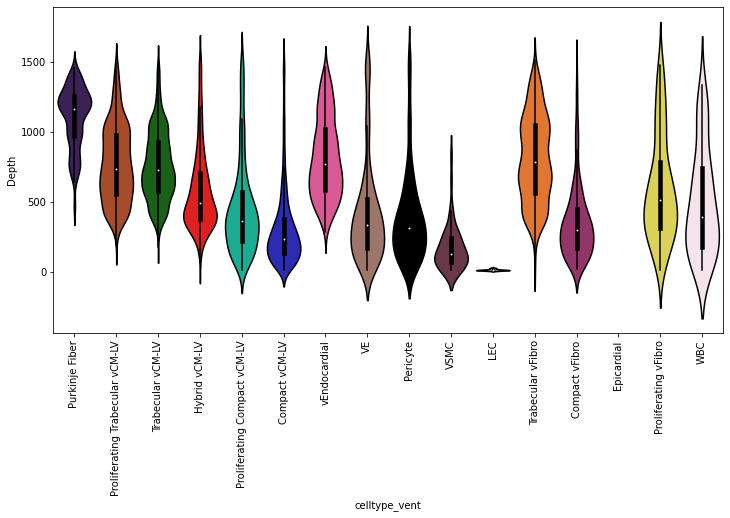

In [5]:
data = adata_merfish_view.obs.loc[:,['celltype_vent','Depth']]

com_order = ['Purkinje Fiber',
             'Proliferating Trabecular vCM-LV',
             'Trabecular vCM-LV',
             'Hybrid vCM-LV',
             'Proliferating Compact vCM-LV',
             'Compact vCM-LV',
             'vEndocardial',
             'VE',
             'Pericyte',
             'VSMC',
             'LEC',
             'Trabecular vFibro',
             'Compact vFibro',
             'Epicardial',
             'Proliferating vFibro',
             'WBC']
data['celltype_vent'] = pd.Categorical(data['celltype_vent'], categories=com_order)

plt.figure(figsize = (12,6))
sns.violinplot(x="celltype_vent", y="Depth", data=data, scale='width', 
               order=data['celltype_vent'].cat.categories, palette = celltype_lv_color)
plt.xticks(rotation=90)
plt.savefig('../figures/Fig4/MERFISH_ventricle_lv_celltype_depth_violin.pdf', bbox_inches='tight')

## Finding depth correlated CM genes

In [11]:
adata_merfish_view_depth = adata_merfish_view[~adata_merfish_view.obs['Depth'].isna()] # make object without NA depth cells

cm_celltypes = ['Compact vCM-LV','Trabecular vCM-LV','Proliferating Compact vCM-LV',
                'Proliferating Trabecular vCM-LV','Comp/Trab vCM','Purkinje Fiber']

adata_merfish_view_depth_cm = adata_merfish_view_depth[adata_merfish_view_depth.obs['celltype_vent'].isin(cm_celltypes)]

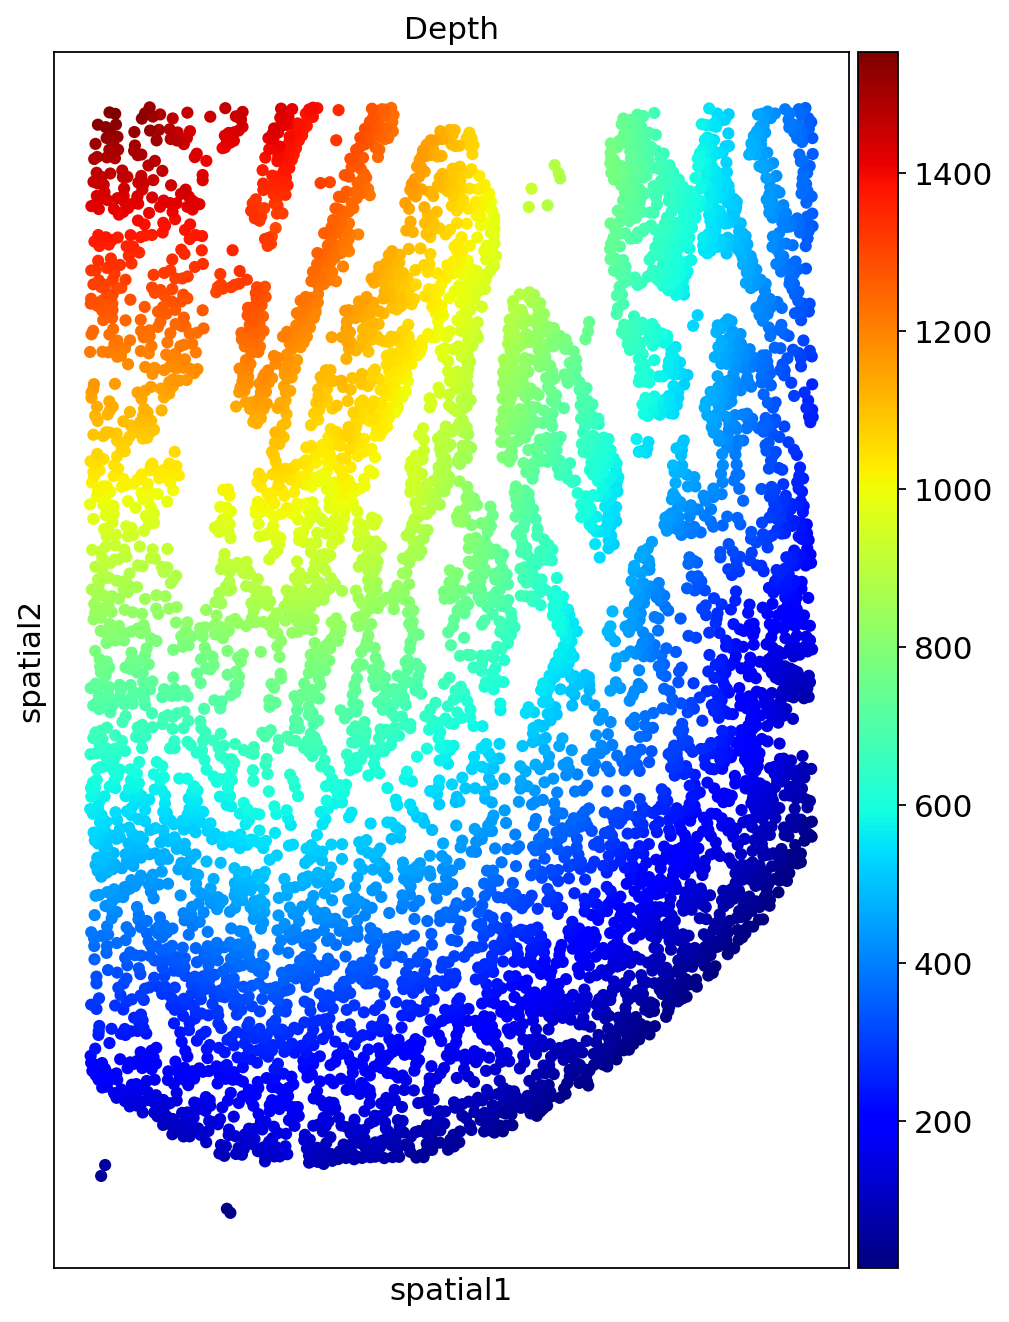

In [14]:
sc.set_figure_params(figsize=[7,10])
sc.pl.embedding(adata_merfish_view_depth_cm, basis="spatial", color="Depth", size=120, 
                return_fig=True, na_color = 'lightgrey', cmap='jet')
plt.savefig('../figures/Fig3/MERFISH_ventricle_lv_spatial_depth.pdf', bbox_inches='tight')
plt.style.use('default')

In [55]:
# calculate correlations
gene_depth_corr_view_cm = np.array([np.corrcoef(adata_merfish_view_depth_cm.obs['Depth'].to_numpy(), 
                                                adata_merfish_view_depth_cm.X[:,i])[0,1] for i in range(adata_merfish_view_depth_cm.X.shape[1])])

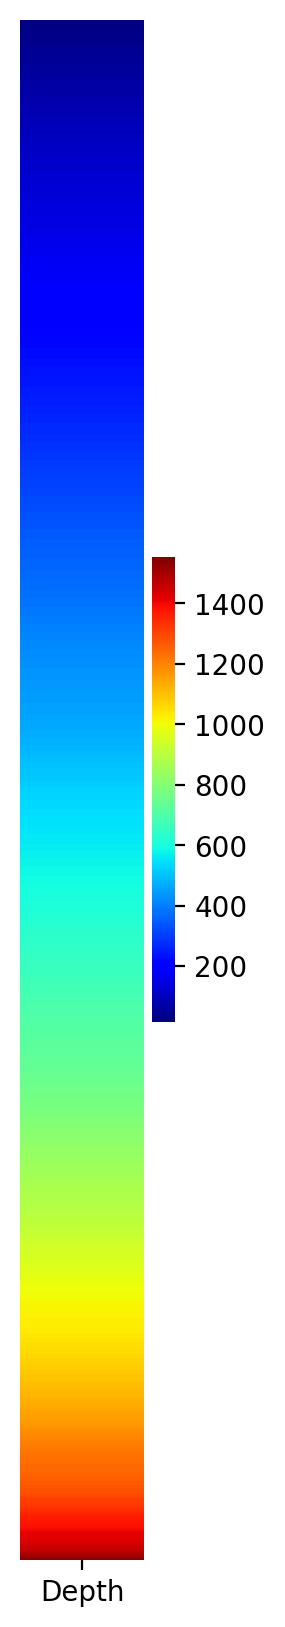

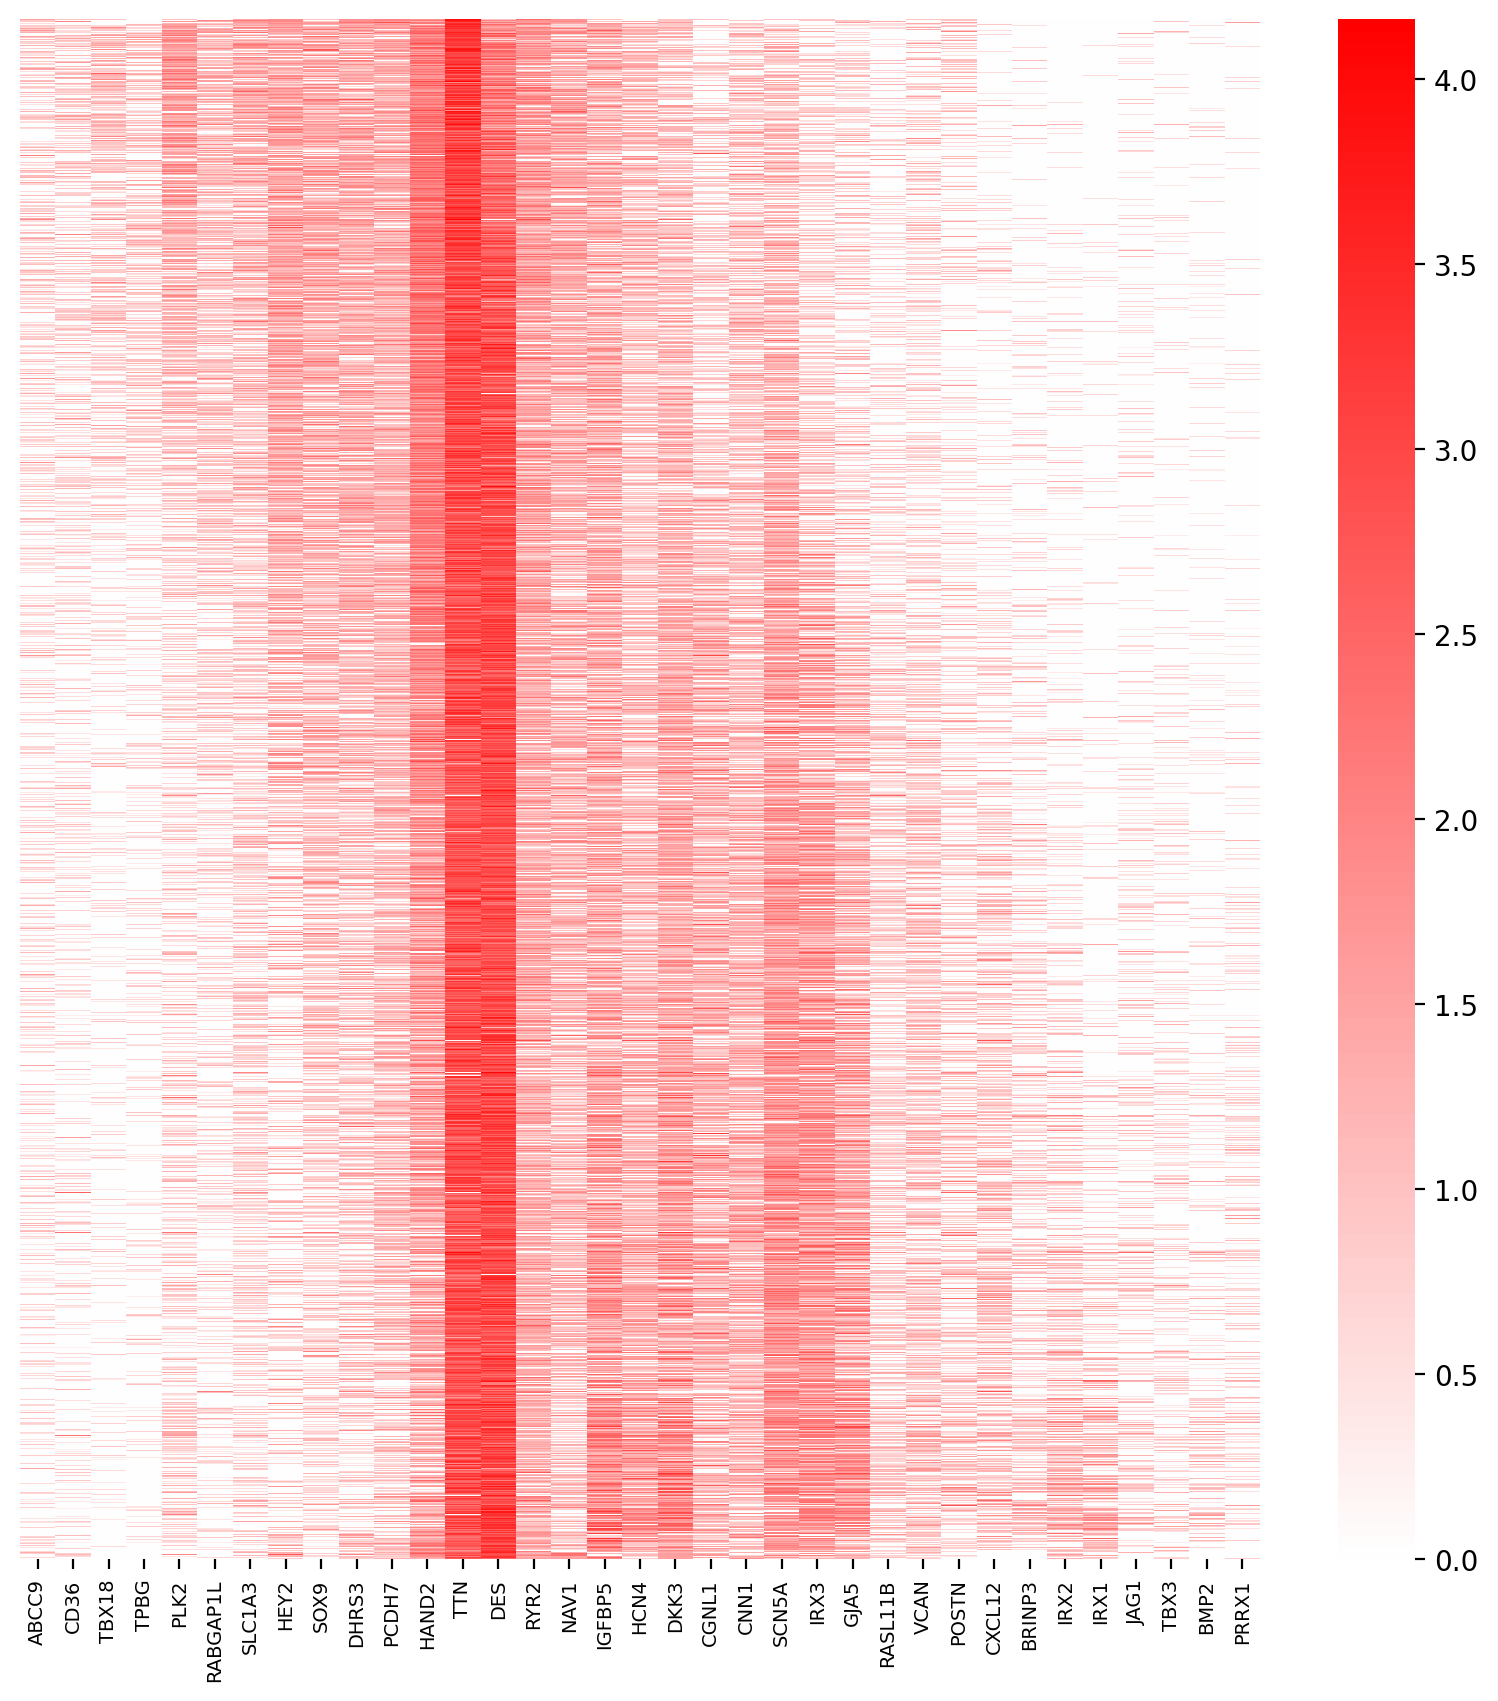

In [57]:
thresh = 0.2

data = pd.DataFrame(adata_merfish_view_depth_cm.X[:,abs(gene_depth_corr_view_cm) > thresh], 
                    index=adata_merfish_view_depth_cm.obs.index,
                    columns=adata_merfish_view_depth_cm.var_names[abs(gene_depth_corr_view_cm) > thresh])

data['Depth'] = adata_merfish_view_depth_cm.obs.loc[data.index,'Depth']
data = data.sort_values('Depth')

plt.figure(figsize=(1,10))
sns.heatmap(data[['Depth']], yticklabels=False, cmap='jet')
plt.savefig('../figures/Fig3/MERFISH_ventricle_lv_depth_corr_gene_heatmap_cell_depths.pdf')

# order by top quantile mean depth
mean_depths = {}
for gene in data.columns:
    if gene == 'Depth': continue
    mean_depths[gene] = data.loc[data[gene] > data[gene].quantile(.90),'Depth'].mean()
gene_order = [t[0] for t in sorted(mean_depths.items(), key=lambda x:x[1])]

gene_order = ['ABCC9','CD36','TBX18','TPBG','PLK2','RABGAP1L','SLC1A3','HEY2','SOX9',
              'DHRS3','PCDH7','HAND2','TTN','DES','RYR2','NAV1','IGFBP5','HCN4',
              'DKK3','CGNL1','CNN1','SCN5A','IRX3','GJA5','RASL11B','VCAN','POSTN','CXCL12','BRINP3',
              'IRX2','IRX1','JAG1','TBX3','BMP2','PRRX1']

data = data.loc[:,gene_order]

plt.figure(figsize=(10,10))
p = sns.heatmap(data, yticklabels=False, cmap='bwr', center=0)
p.set_xticklabels(p.get_xmajorticklabels(), fontsize = 7)
plt.savefig('../figures/Fig3/MERFISH_ventricle_lv_depth_corr_gene_heatmap.pdf', bbox_inches='tight')

# vCM subset analysis

In [3]:
vcm_celltypes = ['Compact vCM-LV', 'Proliferating Compact vCM-LV', 'Hybrid vCM-LV', 
                 'Trabecular vCM-LV', 'Proliferating Trabecular vCM-LV', 'Purkinje Fiber']

adata_merfish_cm = adata_merfish_subset[adata_merfish_subset.obs['celltype_vent'].isin(vcm_celltypes)]

In [4]:
sc.pp.pca(adata_merfish_cm)
sc.pp.neighbors(adata_merfish_cm)
sc.tl.umap(adata_merfish_cm)

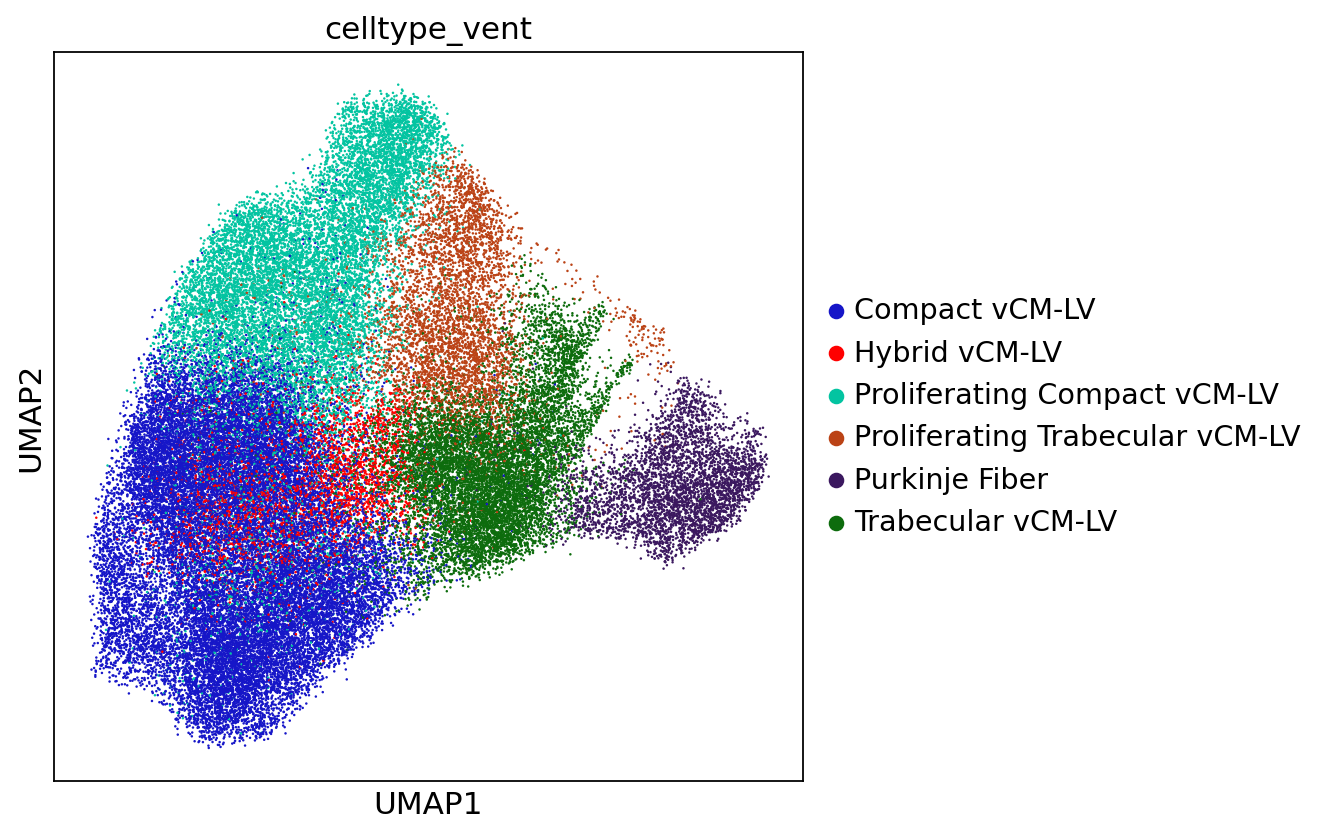

In [5]:
sc.set_figure_params(figsize=[6,6])
p = sc.pl.umap(adata_merfish_cm, color="celltype_vent", size=5, show=False)
plt.savefig('../figures/Fig3/MERFISH_ventricle_lv_depth_corr_gene_heatmap.pdf', bbox_inches='tight')
plt.style.use('default')

## PAGA

In [6]:
sc.tl.paga(adata_merfish_cm, groups='celltype_vent')

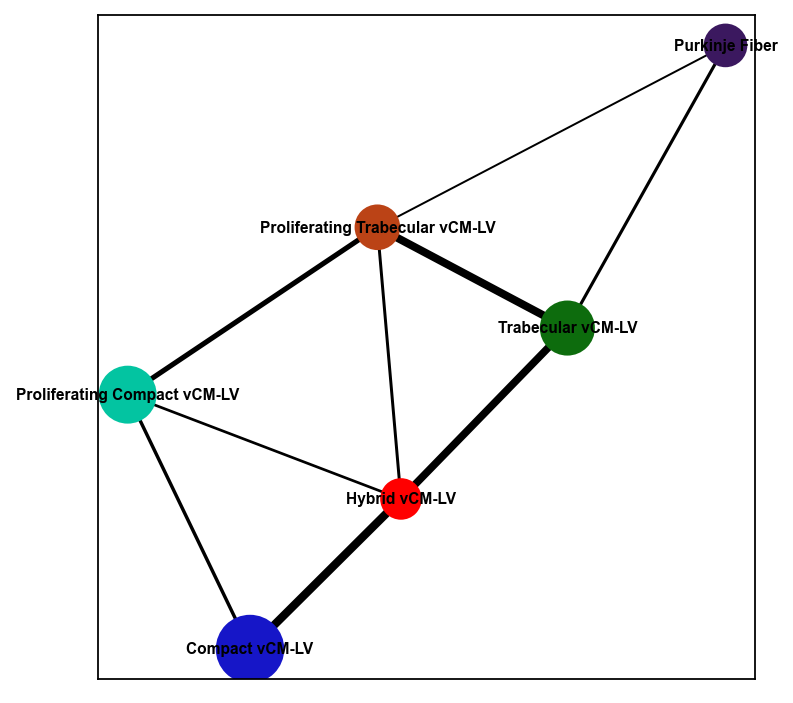

In [16]:
sc.set_figure_params(figsize=[5,5])
sc.pl.paga(adata_merfish_cm, node_size_scale=3, edge_width_scale=0.6, fontsize=7, show=False, threshold=0.05)
plt.savefig('../figures/Fig3/MERFISH_ventricle_lv_cm_paga.pdf', bbox_inches='tight')

## Psuedotime vs Depth

In [8]:
# Select Compact vCM-LV cell with highest HEY2 expression as root of trajectory
adata_merfish_lv_comp = adata_merfish_cm[adata_merfish_cm.obs['celltype_vent']=='Compact vCM-LV', 'HEY2']
root_cell = adata_merfish_lv_comp.obs.index[adata_merfish_lv_comp[:, 'HEY2'].X.argmax()]
adata_merfish_cm.uns['iroot'] = adata_merfish_cm.obs.index.get_loc(root_cell)

sc.tl.dpt(adata_merfish_cm)

In [12]:
adata_merfish_view_depth_cm.obs['dpt_pseudotime'] = adata_merfish_cm.obs.loc[adata_merfish_view_depth_cm.obs.index,'dpt_pseudotime']

Trying to set attribute `.obs` of view, copying.


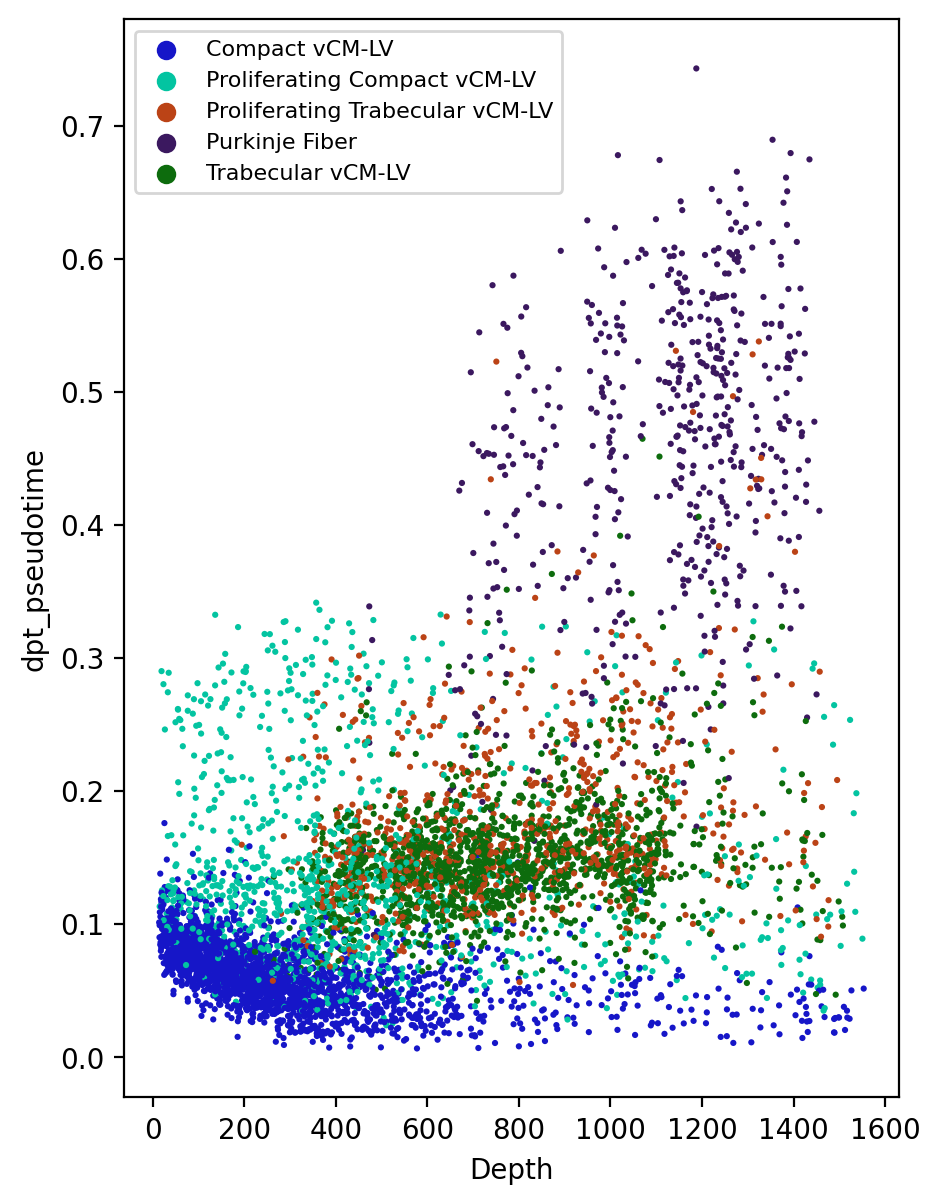

In [23]:
plt.style.use('default')
plt.figure(figsize=(5,7))
sns.scatterplot(data=adata_merfish_view_depth_cm.obs, 
                x="Depth", y="dpt_pseudotime", hue="celltype_vent", s=5, 
                linewidth=0, palette=adata_merfish_view_depth_cm.uns['celltype_vent_colors'].tolist())
plt.legend(prop={'size': 8})
plt.savefig('../figures/Fig3/MERFISH_ventricle_lv_cm_pseudotime_vs_depth_scatter.pdf', bbox_inches='tight')